# Meta Estimator for Stacked Clustering Models

Joseph Wagner

### Imports & Data Ingestion

In [54]:
from IPython.display import Image
import numpy as np
import pandas as pd
from pprint import pprint
import stackprinter

pd.set_option('display.max_columns', None)
stackprinter.set_excepthook(style='lightbg')

In [2]:
repos_df = pd.read_pickle('./Data/repo_200.pk1')

In [3]:
repos_df.shape

(200, 24)

In [4]:
repos_df.head()

,createdAt,description,totalForks,hasIssuesEnabled,hasWikiEnabled,id,totalIssues,licenseInfo,name,nameWithOwner,readMe,owner,primaryLanguage,totalPullRequests,totalCommits,totalStargazers,updatedAt,commit_count,issue_count,pull_request_count,stars_count,pr_duration,pr_assoc,is_assoc
0,2016-08-21 05:31:51+00:00,An android process bar library associated with...,37,True,True,MDEwOlJlcG9zaXRvcnk2NjE4Mjg1MA==,0,None,android_ProcessBar,hzw1199/android_ProcessBar,# Process Bar\n[![](https://jitpack.io/v/hzw11...,hzw1199,Java,0,10.0,199,2019-08-28 06:14:45+00:00,"[[9, 1]]",None,None,"[[143, 16, 3, 6, 2, 2, 1, 2, 3, 3, 1, 2, 1, 1,...",None,None,None
1,2015-10-20 18:22:34+00:00,A ScrollView component that handles keyboard a...,377,True,True,MDEwOlJlcG9zaXRvcnk0NDYyNjI1MA==,272,MIT,react-native-keyboard-aware-scroll-view,APSL/react-native-keyboard-aware-scroll-view,# react-native-keyboard-aware-scroll-view\n\n<...,APSL,JavaScript,110,166.0,3118,2019-09-09 21:17:49+00:00,"[[2, 6, 2, 1, 4, 7, 9, 1, 5, 2, 6, 4, 3, 7, 4,...","[[2, 3, 2, 10, 14, 6, 6, 5, 3, 5, 5, 5, 7, 3, ...","[[1, 1, 3, 6, 2, 5, 3, 4, 2, 4, 4, 2, 2, 5, 5,...","[[1, 17, 2, 7, 5, 6, 16, 13, 27, 30, 39, 38, 4...","[[11 days 02:17:31, 521 days 17:08:22, 2 days ...",CONTRIBUTOR MEMBER NONE OW...,CONTRIBUTOR MEMBER NONE OW...
2,2015-11-24 12:43:44+00:00,Sample app to demonstrate multidex,51,True,True,MDEwOlJlcG9zaXRvcnk0Njc5MTAyMg==,1,None,multidex-sample,mmadev/multidex-sample,# multidex-sample\nSample app to demonstrate m...,mmadev,Java,0,2.0,118,2019-03-22 01:44:33+00:00,[[2]],[[1]],None,"[[27, 20, 8, 1, 5, 3, 4, 5, 2, 4, 4, 1, 1, 3, ...",None,None,CONTRIBUTOR MEMBER NONE OWNER C...
3,2015-10-05 09:34:22+00:00,multiNetX is a python package for the manipula...,31,True,True,MDEwOlJlcG9zaXRvcnk0MzY3NTc1OQ==,6,None,multinetx,nkoub/multinetx,![png](logo.png) multiNetX v2.0 \n=========\n\...,nkoub,Jupyter Notebook,3,70.0,104,2019-08-22 15:04:41+00:00,"[[41, 12, 3, 3, 2, 1, 3, 5]]","[[1, 1, 1, 1, 1, 1]]","[[1, 2]]","[[1, 40, 4, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1...","[[4 days 04:09:04, 0 days 03:50:42]]",CONTRIBUTOR MEMBER NONE OWNER C...,CONTRIBUTOR MEMBER NONE OWNER C...
4,2013-07-18 14:39:58+00:00,Painlessly create beautiful matplotlib plots.,140,True,True,MDEwOlJlcG9zaXRvcnkxMTUwNTIxOA==,64,MIT,prettyplotlib,olgabot/prettyplotlib,# Announcement\n\nThank you to everyone who ha...,olgabot,Python,37,252.0,1482,2019-09-09 13:16:14+00:00,"[[3, 70, 8, 18, 3, 27, 35, 12, 21, 12, 15, 17,...","[[1, 5, 1, 3, 10, 4, 5, 4, 2, 9, 4, 4, 1, 1, 1...","[[1, 4, 3, 8, 2, 1, 3, 5, 4, 3, 1, 1, 1]]",None,"[[1 days 12:00:22, 54 days 08:35:33.750000, 1 ...",CONTRIBUTOR MEMBER NONE OWNE...,CONTRIBUTOR MEMBER NONE O...


### Type Conversions & Encodings for PCA

**Design note**: Instead of mutating columns `inplace`, I'll build up a new `DataFrame` consisting of numeric data from `repos_df`.

* Divide total values by age of the repo

In [5]:
from category_encoders.ordinal import OrdinalEncoder as OrdEnc

In [6]:
pca_df = pd.DataFrame()

In [7]:
# Replace missing values for all columns
repos_df = repos_df[:].replace(np.NaN, 0)
repos_df = repos_df[:].replace('None', 0)

# Convert pd.Timestamp-type columns to float for PCA
time_cols = ['createdAt', 'updatedAt']
for column in time_cols:
    pca_df[column] = repos_df[column].values.astype('datetime64').astype(int).astype(float)

# Check Timestamp conversion
print(pca_df['createdAt'].iloc[0])
pca_df[['createdAt','updatedAt']].dtypes

1.471757511e+18


/home/joseph/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/joseph/.local/lib/python3.7/site-packages/pandas/core/missing.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


createdAt    float64
updatedAt    float64
dtype: object

In [8]:
# Convert boolean cols to integer
bool_cols = ['hasIssuesEnabled', 'hasWikiEnabled']
for column in bool_cols:
    pca_df[column] = repos_df[column].astype(np.int8)

# Check Boolean conversion
pca_df[['hasIssuesEnabled', 'hasWikiEnabled']].dtypes

hasIssuesEnabled    int8
hasWikiEnabled      int8
dtype: object

In [9]:
# Append numeric cols from repos_df to pca_df
numeric_cols = ['totalForks', 'totalIssues', 'totalPullRequests', 'totalCommits', 'totalStargazers']
for column in numeric_cols:
    pca_df[column] = repos_df[column].astype(np.int16)

pca_df[['totalForks', 'totalIssues', 'totalPullRequests', 'totalCommits', 'totalStargazers']].dtypes

totalForks           int16
totalIssues          int16
totalPullRequests    int16
totalCommits         int16
totalStargazers      int16
dtype: object

In [10]:
# Use Ordinal encoding for low-cardinality string cols
ordinal_cols = ['licenseInfo', 'primaryLanguage']
for column in ordinal_cols:
    encoder = OrdEnc()
    pca_df[column] = encoder.fit_transform(repos_df[column].values).astype(np.int8)

pca_df[['licenseInfo', 'primaryLanguage']].dtypes

licenseInfo        int8
primaryLanguage    int8
dtype: object

In [11]:
# Set pca_df indices to respective repo names
pca_df.index = repos_df['name']

# Dropping these columns for due to interference with clustering
pca_df.drop(axis='columns', labels=['createdAt','updatedAt'], inplace=True)

pca_df.head()

,hasIssuesEnabled,hasWikiEnabled,totalForks,totalIssues,totalPullRequests,totalCommits,totalStargazers,licenseInfo,primaryLanguage
name,,,,,,,,,
android_ProcessBar,1,1,37,0,0,10,199,1,1
react-native-keyboard-aware-scroll-view,1,1,377,272,110,166,3118,2,2
multidex-sample,1,1,51,1,0,2,118,1,1
multinetx,1,1,31,6,3,70,104,1,3
prettyplotlib,1,1,140,64,37,252,1482,2,4


### Scale `pca_df`

https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

> For each value in a feature, `MinMaxScaler` subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum. `MinMaxScaler` preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data. Note that `MinMaxScaler` doesn’t reduce the importance of outliers. The default range for the feature returned by `MinMaxScaler` is 0 to 1.

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler(feature_range=(0,1), copy=True)
scaled_pca_array = scaler.fit_transform(pca_df)

In [33]:
scaled_pca_array

array([[1.00000000e+00, 1.00000000e+00, 1.82492159e-03, ...,
        6.68850198e-03, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 2.12147134e-02, ...,
        1.07326323e-01, 7.69230769e-02, 2.85714286e-02],
       [1.00000000e+00, 1.00000000e+00, 2.62332478e-03, ...,
        3.89588002e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 3.42172797e-03, ...,
        7.65385278e-03, 0.00000000e+00, 1.42857143e-01],
       [1.00000000e+00, 1.00000000e+00, 2.11006558e-03, ...,
        2.64437166e-02, 2.30769231e-01, 8.57142857e-02],
       [1.00000000e+00, 1.00000000e+00, 5.13259196e-04, ...,
        1.68591622e-02, 7.69230769e-02, 2.85714286e-02]])

### PCA Dimensionality Reduction

In [12]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=6)
# pca_array = pca.fit_transform(pca_df.values)
pca_array = pca.fit_transform(scaled_pca_array)

In [35]:
pca_array[::20]

array([[-1.10799340e-01, -2.40483536e-01, -1.08799724e-01,
        -1.15842679e-01,  7.58921460e-03, -9.59477272e-03],
       [-1.20437641e-01, -1.55942930e-01, -9.50827092e-02,
        -1.14584027e-01,  9.20715314e-03, -7.53342919e-03],
       [ 8.85008011e-01, -4.27600636e-02, -1.49256917e-02,
        -1.12684299e-01, -2.20280567e-02, -8.44638045e-02],
       [-1.13469358e-01, -2.13043305e-01, -9.98285212e-02,
        -1.16403549e-01,  3.14883237e-03, -6.78410124e-03],
       [ 8.43414960e-01,  1.67406527e-01, -1.45322324e-01,
        -6.55276516e-02, -1.69353183e-02, -8.50670375e-02],
       [-2.04622604e-01,  5.47854222e-01, -3.43444256e-02,
        -8.69993963e-02, -3.47385798e-02,  2.81584470e-02],
       [-2.06607213e-01,  6.00197618e-01, -8.35262825e-03,
        -1.11282256e-02, -3.66371845e-02,  2.97948024e-02],
       [ 7.63802974e-01,  7.91357532e-01, -1.17995065e-01,
        -1.13427689e-01, -5.29410362e-02, -5.38989050e-02],
       [-1.58015743e-01,  2.83612588e-01,  3.599

### 3 Clustering Models as Base Estimators

In [36]:
Image(url='https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png', height=800, width=800)

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # AffinityPropagation, SpectralClustering

In [38]:
# 2 clusters for differentiating between "successful" and "unsuccessful" repos
kmeans = KMeans(n_clusters=2, random_state=42, max_iter=1000, n_jobs=-1)

data2D = kmeans.fit_transform(pca_array)
y_pred = kmeans.fit_predict(pca_array)

In [39]:
# X,y coordinates after transformation
coord_df = pd.DataFrame(data2D, columns=['X','Y'])

In [40]:
# Centroids of observations
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1]


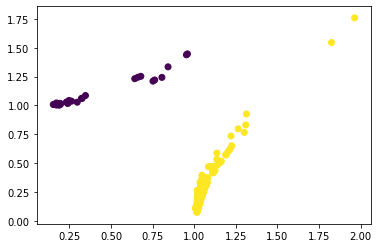

In [41]:
plt.scatter(coord_df['X'], coord_df['Y'], c=y_pred);

In [58]:
# get indices of y_pred 0s to see what repos are outliers
index_list = []
for ind, obs in enumerate(y_pred):
    if obs == 0:
        index_list.append(ind)

In [56]:
y_pred_0s = []
for ind in index_list:
    y_pred_0s.append(pca_df.index[ind])

print(y_pred_0s)

['grace', 'standard', 'monod', 'jrnl', 'elixir', 'IndexedDB', 'carbon', 'open-event-frontend', 'owl', 'fuzzysearch', 'MediaPlayer-Extended', 'pyxl', 'python-iocextract', 'subtome', 'graphiql', 'googleplay-api', 'ac-js2', 'webscalesql-5.6', 'alwsl', 'ufo', 'thunderpush', 'Adafruit_BMP280_Library', 'restfb', 'acl-ue4-plugin', 'kob']


In [57]:
y_pred_1s = []
for ind in range(0,200):
    if ind not in index_list:
        y_pred_1s.append(pca_df.index[ind])

print(y_pred_1s)

['android_ProcessBar', 'react-native-keyboard-aware-scroll-view', 'multidex-sample', 'multinetx', 'prettyplotlib', 'GithubFinder', 'LeetCode', 'squirrel', 'redoc', 'smoothing', 'SharpRepository', 'leetcode', 'protobuf-codec', 'ratos', 'preact-compat', 'raspberry-pi-web-simulator', 'KNPathTableViewController', 'MatchModels', 'django-favorites', 'MacDeveloper', 'analytics.js-integrations', 'Slogger', 'PrimeDatePicker', 'awesome-atom-packages', 'sicp-study', 'tika-similarity', 'VENTouchLock', 'aurelia-materialize-bridge', 'FaceDetect', 'jquery-rails', 'LiteBSD', 'recheck-web', 'nosql-database.org', 'eShopOnContainers', 'sqlite-erlang', 'semaphore', 'mzitu', 'FlexiblePageControl', 'pyofc2', 'Arduino-IRremote', 'grid-window', 'androiddev', 'go-internal', 'KSToastView', 'static-vectors', 'net-irc', 'LPCNet', 'tinypc', 'docker-symfony', 'cv-maker', 'angularfire2', 'haxe', 'magic_numbers', 'cssgrid', 'bCNC', 'JSNetworkX', 'dwv', 'CRGradientNavigationBar', 'react-native-timeline-listview', 'boo

---------------
#### `y_pred_0s` vs `y_pred_1s` Result

* It seems that the **0 values are less popular repos overall** (with some exceptions), and that the majority of the **1 values are popular repos**. 
* There are some repos in the 1s list that are closer to the popularity level of the 0s list. 
* The model needs fine-tuning, but for now I'll continue with the next clustering model so as to get to building the meta estimator.

-------------

In [59]:
from sklearn.cluster import AgglomerativeClustering 

In [100]:
ac_model = AgglomerativeClustering(n_clusters=2, linkage='ward', affinity='euclidean', compute_full_tree=True)

y = ac_model.fit_predict(coord_df.values)

In [101]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0])

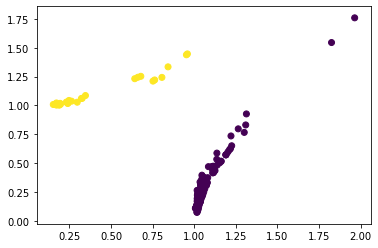

In [102]:
plt.scatter(coord_df['X'], coord_df['Y'], c=y);

In [106]:
# get indices of y 0s
index_list = []
for ind, obs in enumerate(y):
    if obs == 0:
        index_list.append(ind)

y_0s = []
for ind in index_list:
    y_0s.append(pca_df.index[ind])
print('y_0s: \n', y_0s, '\n')

y_1s = []
for ind in range(0,200):
    if ind not in index_list:
        y_1s.append(pca_df.index[ind])

print('y_1s: \n', y_1s)

y_0s: 
 ['android_ProcessBar', 'react-native-keyboard-aware-scroll-view', 'multidex-sample', 'multinetx', 'prettyplotlib', 'GithubFinder', 'LeetCode', 'squirrel', 'redoc', 'smoothing', 'SharpRepository', 'leetcode', 'protobuf-codec', 'ratos', 'preact-compat', 'raspberry-pi-web-simulator', 'KNPathTableViewController', 'MatchModels', 'django-favorites', 'MacDeveloper', 'analytics.js-integrations', 'Slogger', 'PrimeDatePicker', 'awesome-atom-packages', 'sicp-study', 'tika-similarity', 'VENTouchLock', 'aurelia-materialize-bridge', 'FaceDetect', 'jquery-rails', 'LiteBSD', 'recheck-web', 'nosql-database.org', 'eShopOnContainers', 'sqlite-erlang', 'semaphore', 'mzitu', 'FlexiblePageControl', 'pyofc2', 'Arduino-IRremote', 'grid-window', 'androiddev', 'go-internal', 'KSToastView', 'static-vectors', 'net-irc', 'LPCNet', 'tinypc', 'docker-symfony', 'cv-maker', 'angularfire2', 'haxe', 'magic_numbers', 'cssgrid', 'bCNC', 'JSNetworkX', 'dwv', 'CRGradientNavigationBar', 'react-native-timeline-listvie